#  Mounting Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Essential Libraries and Setting Up Environment

In [ ]:
#  Basic Python Libraries for File Handling
import os as operating_sys
from glob import glob as find_files
import pathlib as pathlib_utils

# Libraries for Image Processing
import cv2 as opencv_img

# Libraries for Numerical & Data Handling
import numpy as npy
import pandas as pdx

# Visualization Libraries
import matplotlib.pyplot as pltx
import seaborn as sns_theme

# Scikit-learn for Splitting Data
from sklearn.model_selection import train_test_split as split_data

# Hide verbose log messages.Setting Environment Variables to Hide Logs
operating_sys.environ['GRPC_VERBOSITY'] = 'NONE'
operating_sys.environ['GLOG_minloglevel'] = '2'
operating_sys.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import TensorFlow & Keras (Deep Learning Libraries)
import tensorflow as tf_core
from tensorflow.keras import backend as keras_backend

# Building Deep Learning Models (Customizable parts of Keras)
from tensorflow.keras.models import Model as KModel
from tensorflow.keras.layers import (
    Input as InputLayer,
    Conv2D as ConvLayer,
    MaxPooling2D as MaxPool,
    concatenate as merge_layers,
    Conv2DTranspose as Deconv,
    Activation as ActLayer,
    BatchNormalization as NormLayer,
    Dropout as DropLayer
)

# Callbacks (to control training behavior)
from tensorflow.keras.callbacks import EarlyStopping as StopEarly
from tensorflow.keras.optimizers import Adamax as OptimizerAdamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgAugmentor
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard


I have imported all the important libraries I need for this deep learning project, mainly focused on brain tumor segmentation. I started by importing basic Python libraries like os, glob, and pathlib to handle files and folders. For working with medical images, I have used OpenCV (cv2). To handle numerical data and data tables, I have imported NumPy and Pandas.

For visualization, I have used Matplotlib and Seaborn to create clean and attractive graphs. I’ve also imported scikit-learn to split my dataset into training and validation sets. To keep the output neat, I have set environment variables to hide unnecessary TensorFlow logs.

For building the deep learning model, I have imported TensorFlow and Keras, using layers like convolution, pooling, dropout, etc., to make a flexible model structure. Along with that, I’ve imported useful callbacks like EarlyStopping (to stop training if needed), ModelCheckpoint (to save the best model), ReduceLROnPlateau (to reduce learning rate when stuck), and TensorBoard (to visualize training progress).

# Setting Seaborn Plot Style

In [ ]:
sns_theme.set_style('darkgrid') #set the visual style for your plots when using Seaborn

I will use Matplotlib to create the plots, but I’ve added Seaborn to make them look better. By using sns_theme.set_style('darkgrid'), Matplotlib will apply Seaborn’s cleaner, more polished style. That’s why the plots will have a nicer background and clear gridlines. Seaborn won’t actually draw the plots—it just quietly improves the appearance of the plots created by Matplotlib.

# Defining the Root Directory Path for the Dataset

In [ ]:
root= '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m'

I’ve stored the main folder path of my dataset in a variable called root. This way, whenever I need to access any image or mask from that dataset, I don’t have to write the long folder path again and again. It keeps my code neat and easy to manage

# Collecting and Pairing Image and Mask File Paths

In [ ]:
mask_file_paths = find_files(f"{root}/*/*_mask*")
image_file_paths = [file_path.replace('_mask', '') for file_path in mask_file_paths]


I used this code to collect all the mask files from the dataset, and then I generated a matching list of the original MRI images by simply removing '_mask' from their names.

 This makes it  easy to pair each image with its tumor mask later, whether I will be training the model or just visualizing the results.

# Creating a DataFrame to Store Image and Mask Paths

In [ ]:
image_data_df = pdx.DataFrame({'img_path': image_file_paths, 'mask_path': mask_file_paths})


I used this line to create a table where each MRI scan is paired with its matching tumor mask. This makes it easy to work with the data later. Instead of handling images and masks separately, now I have them nicely organized together in one place—like two matching columns in an Excel sheet. It keeps things clean and helps during training or when I want to visualize results.

# Splitting Dataset into Training, Validation, and Test Sets

In [ ]:
train_df, temp_df = split_data(image_data_df, test_size=0.2, random_state=42)
val_df, test_df = split_data(temp_df, test_size=0.5, random_state=42)


I’m splitting my dataset into 3 parts so that my model can learn, check, and test properly.

First, I keep 80% of the data for training — this is what the model actually learns from.

The leftover 20% gets split equally: 10% for validation (to help during training) and 10% for testing (to see how well the model works at the end).
I’ve used random_state=42 so that every time I run this, I get the same split, making results consistent and easy to compare.

# Check for Missing Data in Training Set

In [ ]:
train_df.isnull().sum()


,0
img_path,0
mask_path,0


We use train_df.isnull().sum() to make sure that there are no missing file paths before starting the model training. If any file (either an image or its corresponding mask) is missing, the model won’t be able to load it properly, and this can lead to errors during training. Checking for missing values early helps avoid problems later, just like double-checking that you have everything you need before going on a trip. It ensures smooth and error-free training.

# Model Input Configuration

In [ ]:
image_dimensions = (128, 128, 1)
batch_sz = 32


We resize MRI images to 128×128 because it’s a power of 2, which works better with deep learning models like U-Net. Powers of 2 (like 64, 128, 256) help the model neatly downsample and upsample the images layer by layer. Using 1 channel (grayscale) saves memory and is perfect for MRI scans, which don’t have color—only brightness matters to detect tumors.


The batch size of 32 means the model will process 32 images at a time during training, instead of loading the entire dataset at once. This is like teaching a group of 32 students together—manageable and efficient. Choosing 32 is a common default because it’s not too small to slow things down and not too large to overload the memory. It strikes a good balance between speed and memory usage, especially for tasks like MRI image segmentation. If you have a powerful system, you can increase it, and if you face memory issues, you can lower it—but 32 is usually a safe, balanced choice for deep learning tasks.

# Utility Function to Convert DataFrame into Keras Data Generator

In [ ]:
def dataframe_to_generator(generator_obj, data_frame, column_name, color_mode_type):
    return generator_obj.flow_from_dataframe(
        data_frame,
        x_col=column_name,
        class_mode=None,
        color_mode=color_mode_type,
        target_size=image_dimensions[:2],
        batch_size=batch_sz,
        seed=1
    )


The dataframe_to_generator() function turns a DataFrame of image or mask file paths into a Keras-compatible data generator. It takes in an image augmentation object (generator_obj), the DataFrame containing file paths (data_frame), the column name with the paths (column_name), and the desired color mode (like 'grayscale' for MRI scans). Inside, it uses Keras’s flow_from_dataframe() method to create batches of images: reading paths from the specified column, skipping class labels (since it's for segmentation), applying grayscale mode, resizing each image to a fixed size (128×128), batching them in groups (like 32 images at a time), and setting a seed to ensure consistent shuffling each run. The resulting generator can then feed data efficiently during model training.

# Custom Data Generator for Image–Mask Pair Batching and Preprocessing

In [ ]:
def create_generator(dataframe, augmentations={}):
    img_gen = ImgAugmentor(**augmentations)
    msk_gen = ImgAugmentor(**augmentations)

    image_flow = dataframe_to_generator(img_gen, dataframe, 'img_path', 'grayscale')
    mask_flow = dataframe_to_generator(msk_gen, dataframe, 'mask_path', 'grayscale')

    if not image_flow or not mask_flow:
        return None

    for images, masks in zip(image_flow, mask_flow):
        if images is None or masks is None:
            continue

        if images.shape != masks.shape:
            print(f"Mismatch found! Image shape: {images.shape}, Mask shape: {masks.shape}")




        images /= 255.0
        masks /= 255.0
        masks[masks >= 0.5] = 1
        masks[masks <  0.5] = 0

        yield images, masks



The create_generator() function prepares image and mask data in batches for training a deep learning model. It starts by creating two image augmentation generators — one for MRI images and one for their corresponding tumor masks — using any augmentations provided (like rotation, zoom, etc.).

Next, it uses the dataframe_to_generator() function to convert the input DataFrame into two separate batch generators: one for grayscale images (img_path) and one for grayscale masks (mask_path).

If either generator fails to load properly, it returns None.

Then, the function loops over both generators together using zip(), which pairs each batch of images with its corresponding batch of masks. If either the images or masks are missing in a batch, it skips that batch.

It also checks whether the shapes of the image and mask batches match. If not, it prints a simple warning message showing their dimensions.

Finally, it normalizes the pixel values of images and masks from 0–255 to 0–1, and binarizes the masks so that any pixel ≥ 0.5 becomes 1 (indicating tumor) and any pixel < 0.5 becomes 0 (indicating background).

Each cleaned and processed batch of image–mask pairs is yielded one at a time, ready to be used for model training.

# Why two different generator functions?

The function dataframe_to_generator() is used to create a generator object — it sets up how batches of images or masks should be loaded from a DataFrame, resized, normalized, and prepared for training. However, it doesn’t actually produce any data right away. On the other hand, create_generator() takes those generator objects and actively loops through them to fetch and preprocess one batch at a time (like normalizing and binarizing masks), and then yields them for training. So, dataframe_to_generator() builds the data loader, while create_generator() uses it to supply batches during training.

# Creating Training, Validation, and Test Generators

In [ ]:
train_generator = create_generator(train_df, {
    'rotation_range': 0.2,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'zoom_range': 0.05,
    'horizontal_flip': True,
    'vertical_flip': False # As Brain anatomy is not up down symmetric
})

val_generator = create_generator(val_df)
test_generator = create_generator(test_df)


The code sets up three data generators for training, validation, and testing using the create_generator function. The training generator applies real-time image augmentations (such as rotation, shifting, zooming, and horizontal flipping) to enhance model robustness, as it simulates different variations of the data. The validation generator uses unaltered data from val_df to evaluate the model's performance during training, providing an unbiased measure of generalization. Similarly, the test generator uses the test_df to assess the final model performance, also without any augmentations. These generators help manage memory efficiently and ensure the model trains and evaluates using different sets of data, improving its ability to generalize well on new, unseen data.

# Building a Customised U-Net Model for Image Segmentation

In [ ]:
def build_unet_model(depth_levels=5):
    encoder_layers = [None] * depth_levels
    input_tensor = InputLayer(image_dimensions)

    # Downsampling path
    for i in range(2):
        encoder_layers[0] = ConvLayer(128, (3, 3), padding='same')(input_tensor if i == 0 else activation)
        normalization = NormLayer()(encoder_layers[0])
        activation = ActLayer('relu')(normalization)
    pooling = MaxPool((2, 2))(activation)

    for level in range(1, depth_levels):
        for i in range(3):
            filters = 2 ** (level + 7) if i < 2 else 256
            encoder_layers[level] = ConvLayer(filters, (3, 3), padding='same')(pooling if i == 0 else activation)
            normalization = NormLayer()(encoder_layers[level])
            activation = ActLayer('relu')(normalization)
        pooling = MaxPool((2, 2))(activation)

    # Upsampling path
    for level in reversed(range(depth_levels)):
        deconv = Deconv(2 ** (level + 5), (2, 2), strides=(2, 2), padding='same')(pooling if level == depth_levels - 1 else activation)
        merged = merge_layers([deconv, encoder_layers[level]], axis=3)
        conv = ConvLayer(2 ** (level + 8), (3, 3), padding='same')(merged)
        normalization = NormLayer()(conv)
        activation = ActLayer('relu')(normalization)

    output_tensor = ConvLayer(1, (1, 1), activation='sigmoid')(activation)
    return KModel(inputs=input_tensor, outputs=output_tensor)


The build_unet_model() function constructs a U-Net architecture designed for image segmentation, especially useful in medical imaging like tumor detection. It begins by setting up the input layer and a list to store encoder outputs for skip connections. In the downsampling path (encoder), it applies several convolutional blocks followed by max pooling to reduce the image size and extract features. The first level uses 2 convolution blocks with 128 filters, while the deeper levels use 3 blocks each, increasing the filter size for richer feature extraction.

After encoding, the upsampling path (decoder) begins. It performs transpose convolutions (deconvolutions) to gradually increase the image size, and merges the upsampled output with the corresponding encoder outputs using skip connections. Each merged result is further refined using convolution, normalization, and activation layers. Finally, the model outputs a segmentation mask using a 1×1 convolution with a sigmoid activation to produce values between 0 and 1, suitable for binary classification (e.g., tumor vs. background). The model is returned as a complete Keras Model object, ready for training.

# Dice Coefficient, Dice Loss, and IoU

In [ ]:
def dice_coefficient(true_labels, predicted_labels, epsilon=100):
    true_flat = keras_backend.flatten(true_labels)
    pred_flat = keras_backend.flatten(predicted_labels)
    intersection = keras_backend.sum(true_flat * pred_flat)
    total = keras_backend.sum(true_flat) + keras_backend.sum(pred_flat)
    return (2 * intersection + epsilon) / (total + epsilon)

def dice_loss_function(true_labels, predicted_labels, epsilon=100):
    return -dice_coefficient(true_labels, predicted_labels, epsilon)

def intersection_over_union(true_labels, predicted_labels, epsilon=100):
    intersection = keras_backend.sum(true_labels * predicted_labels)
    union = keras_backend.sum(true_labels + predicted_labels)
    return (intersection + epsilon) / (union - intersection + epsilon)


This code defines three key functions used for evaluating the performance of segmentation models, especially in medical image tasks like tumor detection. The dice_coefficient() function calculates how well the predicted segmentation overlaps with the ground truth, making it ideal for measuring accuracy in small target areas. The dice_loss_function() simply returns the negative of the Dice score, which is useful for training the model because loss functions are minimized during optimization. Lastly, the intersection_over_union() (IoU or Jaccard Index) computes the ratio of the overlapping area to the total area covered by both the prediction and the ground truth. All functions include an epsilon value (default 100) to ensure numerical stability, especially when masks are small or contain few pixels.

# Why Accuracy Is Not the Best Metric for Brain MRI Segmentation

In brain MRI segmentation, especially for detecting tumors, accuracy is not considered the best metric because it can be misleading in imbalanced data. In most MRI scans, the tumor region is very small compared to the healthy brain tissue. So even if a model predicts every pixel as "healthy" and completely misses the tumor, it might still achieve high accuracy (e.g., 98–99%) simply because the majority of pixels are non-tumor. However, such a model is useless in practice because it fails to detect the most critical part — the tumor. Metrics like Dice Coefficient or Intersection over Union (IoU) are preferred instead, because they focus on how well the predicted tumor region overlaps with the actual tumor, giving a much clearer picture of the model's true performance in segmenting medical images.











# Compiling the U-Net Model for Training

In [ ]:
unet_model = build_unet_model()
optimizer=OptimizerAdamax(learning_rate=1e-3)
unet_model.compile(
    optimizer=optimizer,
    loss=dice_loss_function,
    metrics=['accuracy', intersection_over_union, dice_coefficient]
)
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_3[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 116,994,913 (446.30 MB)

 Trainable params: 116,961,121 (446.17 MB)

 Non-trainable params: 33,792 (132.00 KB)

In this code, a U-Net model is created using the build_unet_model() function, designed for segmenting brain tumors from MRI images. The optimizer used is Adamax, a stable variant of the Adam optimizer, with a learning rate of 0.001 for smooth learning. The model is compiled with the Dice Loss function, which is more suitable than accuracy for medical segmentation tasks. Along with the loss, the model also tracks accuracy, Intersection over Union (IoU), and the Dice Coefficient as evaluation metrics. Finally, unet_model.summary() prints a detailed structure of the model layers and parameters. This setup ensures that the model is ready for effective and performance-aware training.

# Model Training with Callbacks

In [ ]:

# ModelCheckpoint ➔ Save only the best model
checkpoint = ModelCheckpoint(
    'BEST_MODEL.keras',     # Filepath to save model
    monitor='val_loss',     # What to watch → Validation Loss
    save_best_only=True,    # Only save if this model is better than the previous one
    mode='min',             # We want to minimize 'val_loss'
    verbose=1
)

# TensorBoard ➔ For visualizing training process
tensorboard = TensorBoard(log_dir='logs')

# EarlyStopping ➔ Stop training early if no improvement
early_stop = StopEarly(
    monitor='val_loss',     # Watch validation loss
    patience=5,             # Wait 5 epochs without improvement before stopping
    restore_best_weights=True  # Restore the best version of the model
)

# ReduceLROnPlateau ➔ Reduce learning rate if stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Watch validation loss
    factor=0.5,             # Reduce LR by 50% if not improving
    patience=3,             # Wait 3 epochs without improvement
    verbose=1
)


history = unet_model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    steps_per_epoch=len(train_df) // batch_sz,
    validation_steps=len(val_df) // batch_sz,
    callbacks=[checkpoint, tensorboard, early_stop, reduce_lr]
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8916 - dice_coefficient: 0.1523 - intersection_over_union: 0.0864 - loss: -0.1523 Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.08510, saving model to BEST_MODEL.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 2503s 25s/step - accuracy: 0.8922 - dice_coefficient: 0.1531 - intersection_over_union: 0.0869 - loss: -0.1531 - val_accuracy: 0.9839 - val_dice_coefficient: 0.0851 - val_intersection_over_union: 0.0483 - val_loss: -0.0851 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9875 - dice_coefficient: 0.3654 - intersection_over_union: 0.2361 - loss: -0.3650
Epoch 2: val_loss did not improve from -0.08510
98/98 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9875 - dice_coefficient: 0.3657 - intersection_over_union: 0.2364 - loss: -0.3654 - val_accuracy: 0.

In this training setup, several callbacks are used to make the training process smarter and more efficient. The ModelCheckpoint callback saves the model only when it performs best on validation data, preventing unnecessary file saving. TensorBoard helps visualize training progress like loss and accuracy in real time. EarlyStopping monitors validation loss and stops training if the model doesn't improve for a few epochs, saving time and preventing overfitting. ReduceLROnPlateau adjusts the learning rate by reducing it if the model stops improving, helping it learn better in later stages. All these callbacks together ensure that the model trains efficiently, learns well, and avoids overfitting or wasted computation.

In [ ]:
import os as operating_sys
import shutil

# Define the directory where you want to save the test data in Colab
local_test_data_dir = '/content/test_data_for_download'

# Create the local directory if it doesn't exist
operating_sys.makedirs(local_test_data_dir, exist_ok=True)

# Iterate through the test_df to copy the files
for index, row in test_df.iterrows():
    img_src_path = row['img_path']
    mask_src_path = row['mask_path']

    # Construct the destination paths
    # We'll keep the original file names but put them in the new local directory
    img_dest_path = operating_sys.path.join(local_test_data_dir, operating_sys.path.basename(img_src_path))
    mask_dest_path = operating_sys.path.join(local_test_data_dir, operating_sys.path.basename(mask_src_path))

    try:
        # Copy the image file
        shutil.copy2(img_src_path, img_dest_path)
        # Copy the mask file
        shutil.copy2(mask_src_path, mask_dest_path)
        # print(f"Copied: {os.path.basename(img_src_path)} and {os.path.basename(mask_src_path)}") # Optional: print progress
    except FileNotFoundError as e:
        print(f"Error copying file: {e}. File not found.")
    except Exception as e:
        print(f"An error occurred while copying file: {e}")

print(f"Finished copying test data to {local_test_data_dir}")

# Now, the test data is in the '/content/test_data_for_download' directory
# in your Colab environment.

Finished copying test data to /content/test_data_for_download


In [ ]:
import shutil

# Destination path in your Google Drive
dest_path = '/content/drive/MyDrive/test_data_backup'

# Copy entire folder
shutil.copytree('/content/test_data_for_download', dest_path)


'/content/drive/MyDrive/test_data_backup'

In [ ]:
#  print(operating_sys.getcwd())  # Print the current working directory
#  print(operating_sys.listdir())  # List files in the current directory

In [ ]:

def visualize_training_metrics(history_log, train_metric, val_metric, best_func):
    train_vals = history_log.history[train_metric]
    val_vals = history_log.history[val_metric]
    best_epoch_idx = best_func(val_vals)
    best_val = val_vals[best_epoch_idx]
    epoch_nums = list(range(1, len(train_vals) + 1))

    pltx.plot(epoch_nums, train_vals, 'r', label=f"Train {train_metric.title()}")
    pltx.plot(epoch_nums, val_vals, 'g', label=f"Val {val_metric.title()}")
    pltx.scatter(best_epoch_idx + 1, best_val, s=150, c='green', label=f"Best Epoch = {best_epoch_idx + 1}")
    pltx.title(f"{train_metric.title()} Over Epochs")
    pltx.xlabel('Epoch')
    pltx.ylabel(train_metric.title())
    pltx.legend()




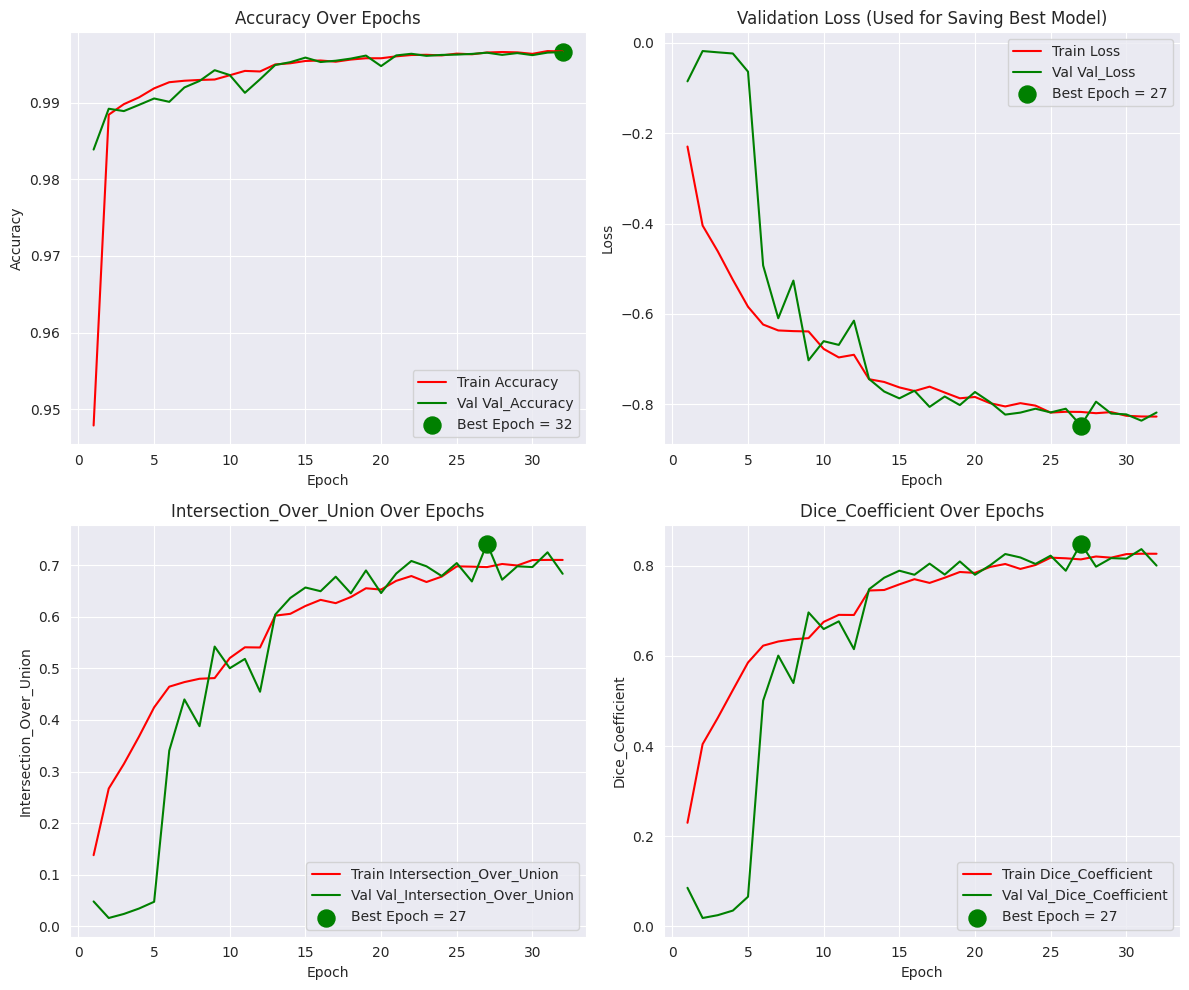

In [ ]:
pltx.figure(figsize=(12, 10))

pltx.subplot(2, 2, 1)
visualize_training_metrics(history, 'accuracy', 'val_accuracy', npy.argmax)

pltx.subplot(2, 2, 2)
visualize_training_metrics(history, 'loss', 'val_loss', npy.argmin)
pltx.title("Validation Loss (Used for Saving Best Model)")

pltx.subplot(2, 2, 3)
visualize_training_metrics(history, 'intersection_over_union', 'val_intersection_over_union', npy.argmax)

pltx.subplot(2, 2, 4)
visualize_training_metrics(history, 'dice_coefficient', 'val_dice_coefficient', npy.argmax)

pltx.tight_layout()
pltx.show()

In [ ]:
print(test_df.columns)

Index(['img_path', 'mask_path'], dtype='object')


In [ ]:
for epoch in range(len(history.history['loss'])):
    print(f"\nEpoch {epoch + 1}")
    print(f"  Accuracy: {history.history['accuracy'][epoch]:.4f}")
    print(f"  Val Accuracy: {history.history['val_accuracy'][epoch]:.4f}")
    print(f"  Loss: {history.history['loss'][epoch]:.4f}")
    print(f"  Val Loss: {history.history['val_loss'][epoch]:.4f}")
    print(f"  IoU: {history.history['intersection_over_union'][epoch]:.4f}")
    print(f"  Val IoU: {history.history['val_intersection_over_union'][epoch]:.4f}")
    print(f"  Dice: {history.history['dice_coefficient'][epoch]:.4f}")
    print(f"  Val Dice: {history.history['val_dice_coefficient'][epoch]:.4f}")



Epoch 1
  Accuracy: 0.9479
  Val Accuracy: 0.9839
  Loss: -0.2295
  Val Loss: -0.0851
  IoU: 0.1380
  Val IoU: 0.0483
  Dice: 0.2295
  Val Dice: 0.0851

Epoch 2
  Accuracy: 0.9884
  Val Accuracy: 0.9892
  Loss: -0.4045
  Val Loss: -0.0181
  IoU: 0.2671
  Val IoU: 0.0162
  Dice: 0.4041
  Val Dice: 0.0181

Epoch 3
  Accuracy: 0.9898
  Val Accuracy: 0.9889
  Loss: -0.4614
  Val Loss: -0.0209
  IoU: 0.3148
  Val IoU: 0.0241
  Dice: 0.4624
  Val Dice: 0.0243

Epoch 4
  Accuracy: 0.9907
  Val Accuracy: 0.9897
  Loss: -0.5247
  Val Loss: -0.0235
  IoU: 0.3679
  Val IoU: 0.0345
  Dice: 0.5243
  Val Dice: 0.0345

Epoch 5
  Accuracy: 0.9919
  Val Accuracy: 0.9905
  Loss: -0.5842
  Val Loss: -0.0636
  IoU: 0.4245
  Val IoU: 0.0476
  Dice: 0.5854
  Val Dice: 0.0653

Epoch 6
  Accuracy: 0.9927
  Val Accuracy: 0.9901
  Loss: -0.6237
  Val Loss: -0.4930
  IoU: 0.4645
  Val IoU: 0.3406
  Dice: 0.6228
  Val Dice: 0.5007

Epoch 7
  Accuracy: 0.9929
  Val Accuracy: 0.9920
  Loss: -0.6368
  Val Loss: -0.

In [ ]:
best_epoch = npy.argmin(history.history['val_loss'])

print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Val Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Val Dice: {history.history['val_dice_coefficient'][best_epoch]:.4f}")
print(f"Val IoU: {history.history['val_intersection_over_union'][best_epoch]:.4f}")


Best Epoch: 27
Best Val Loss: -0.8472
Val Accuracy: 0.9965
Val Dice: 0.8496
Val IoU: 0.7420


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


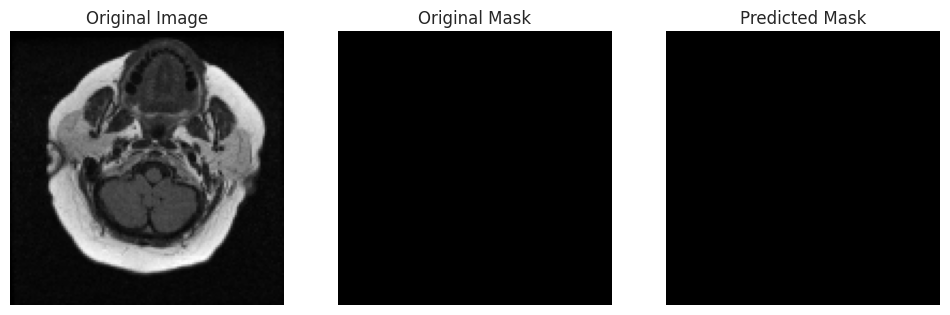

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


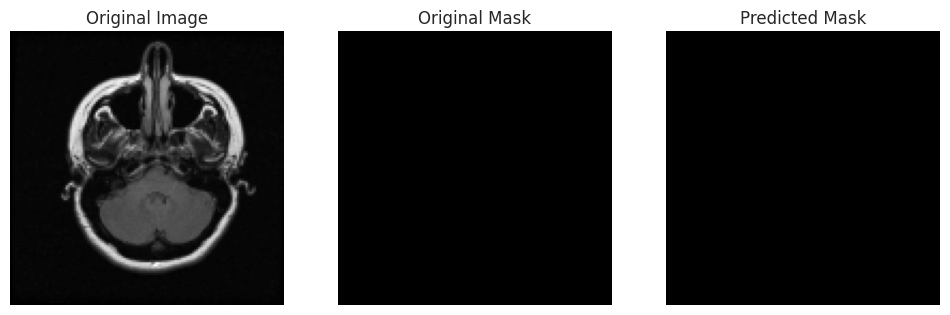

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


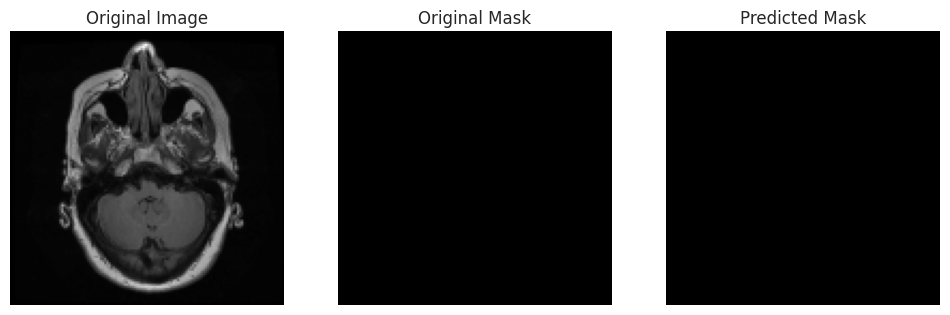

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


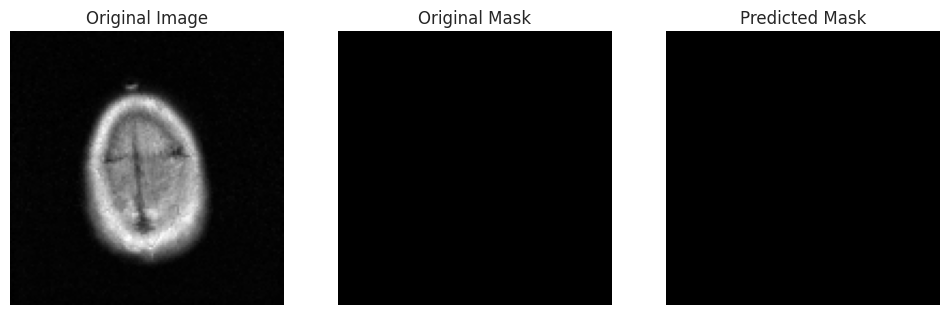

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


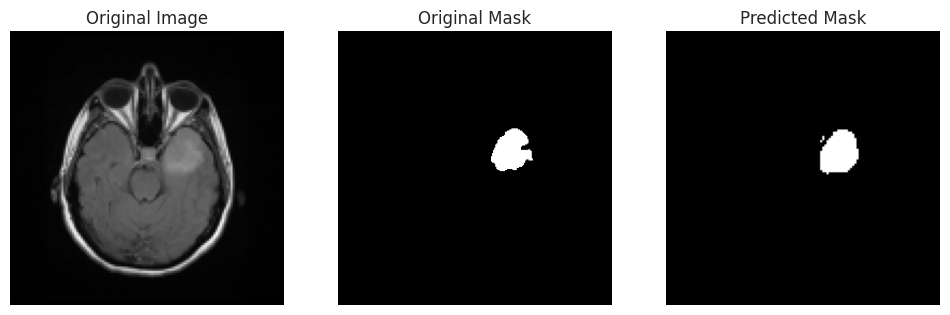

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


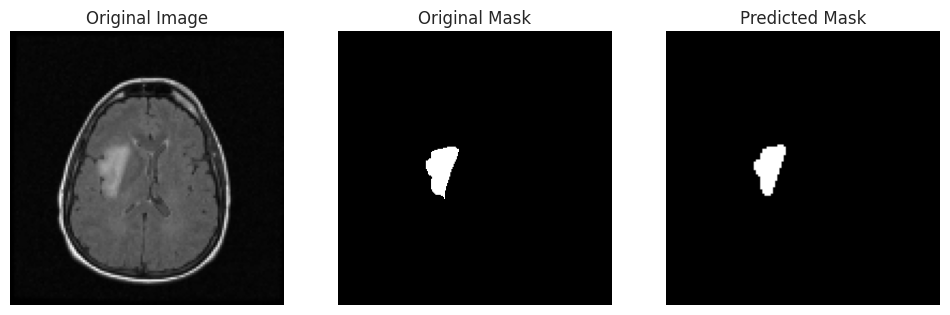

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


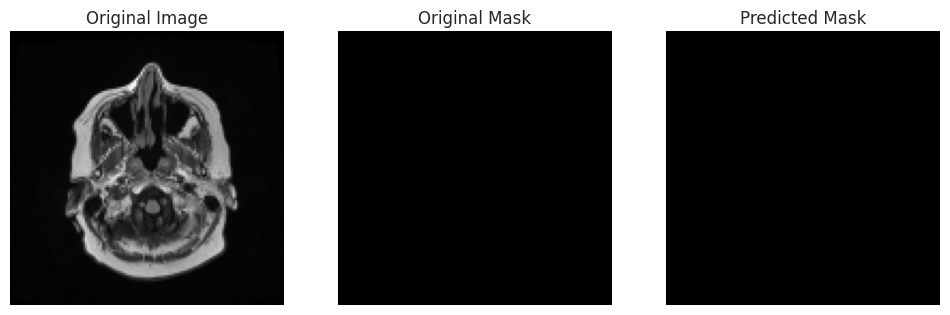

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


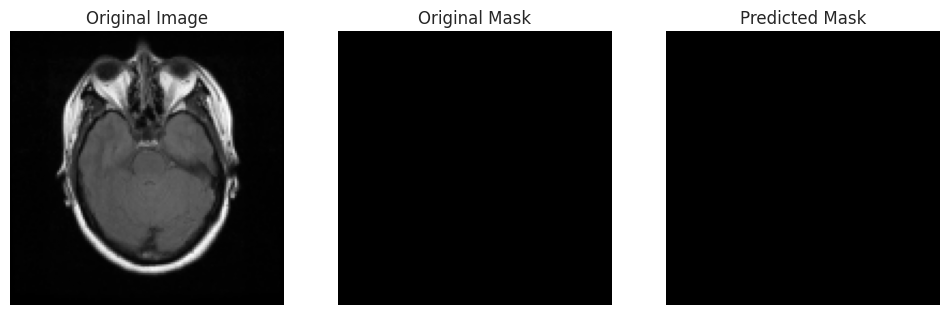

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


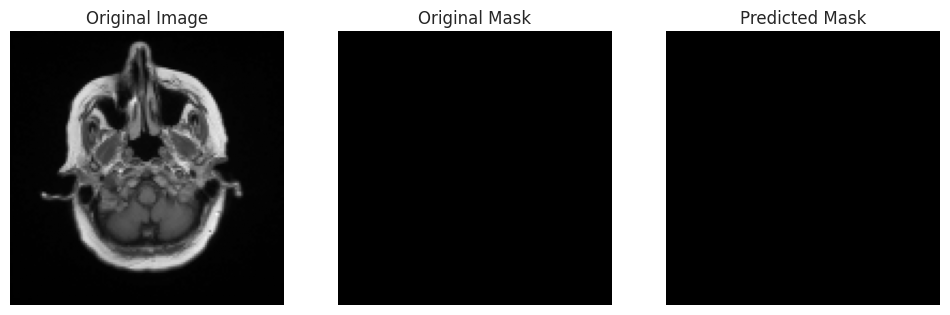

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


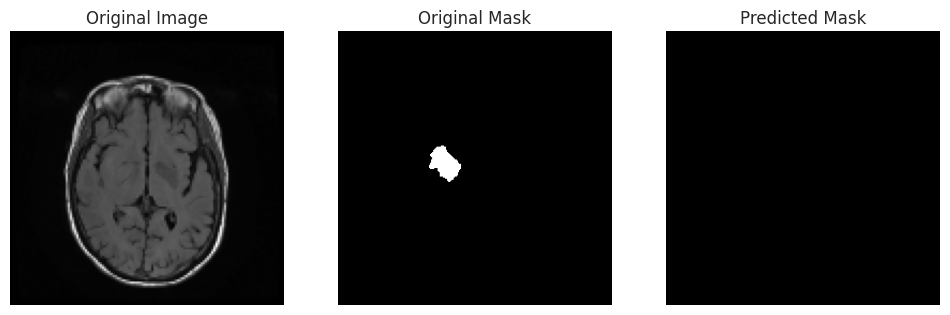

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


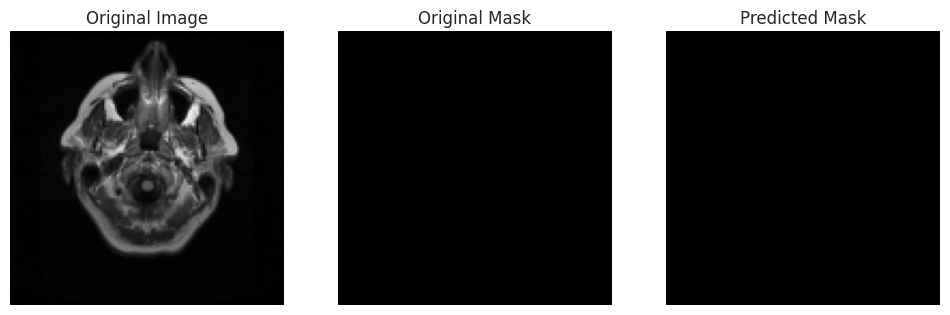

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


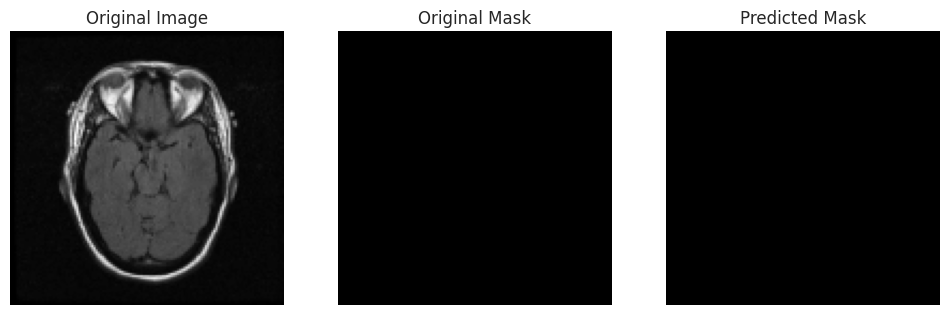

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


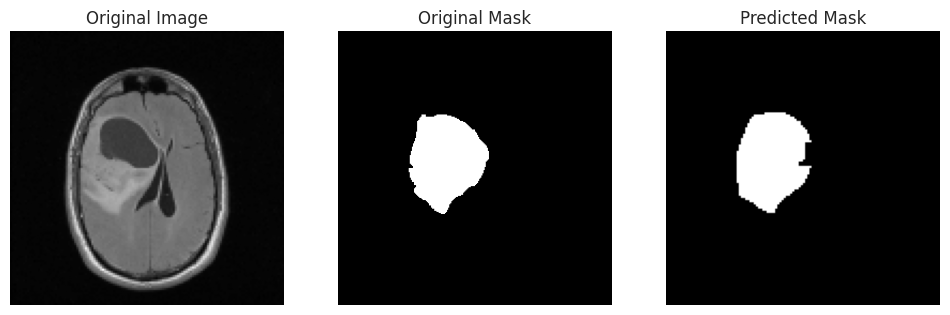

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


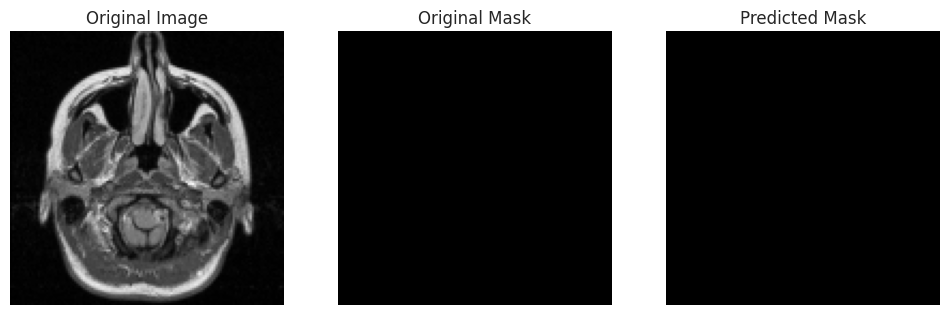

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


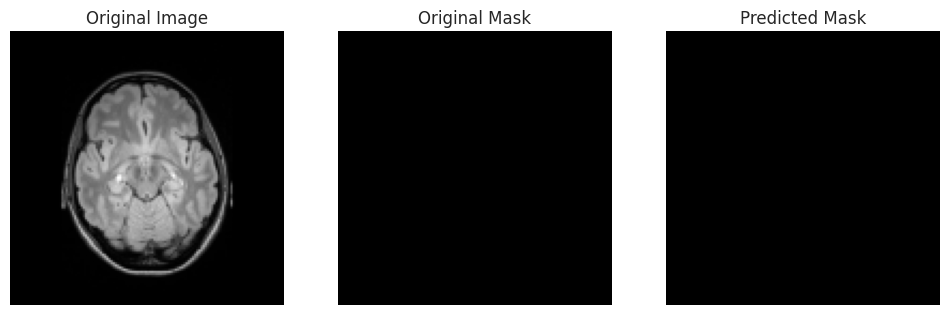

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


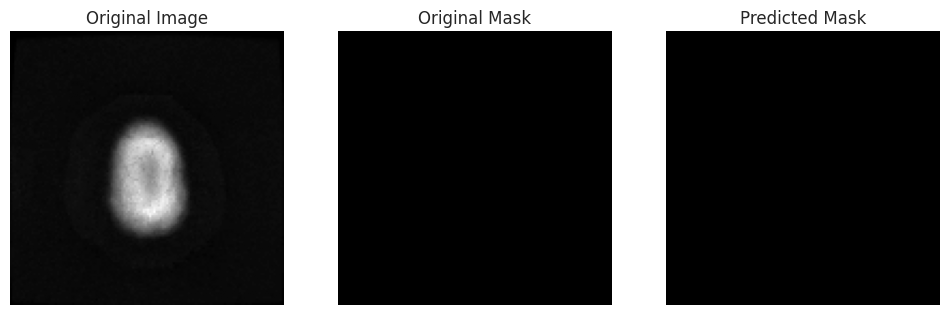

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


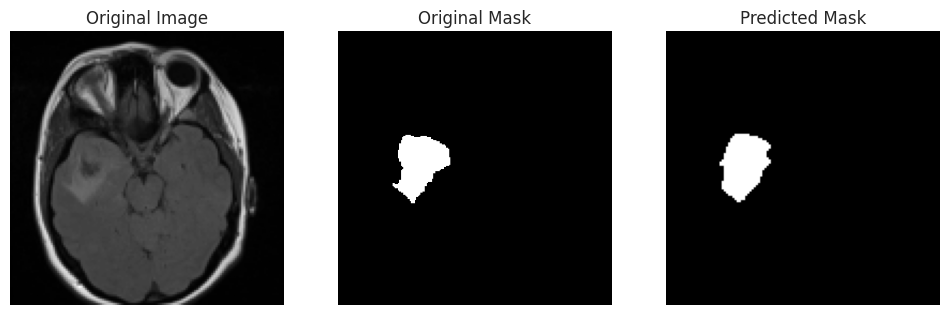

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


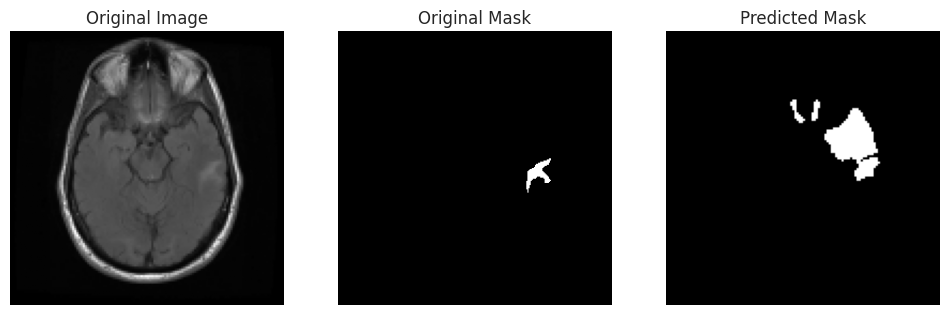

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


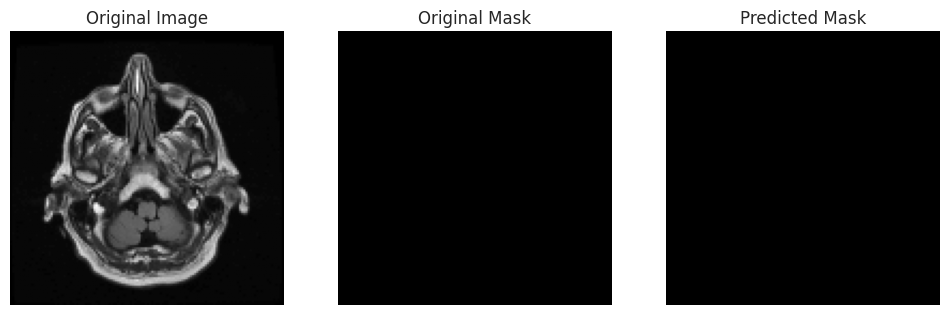

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


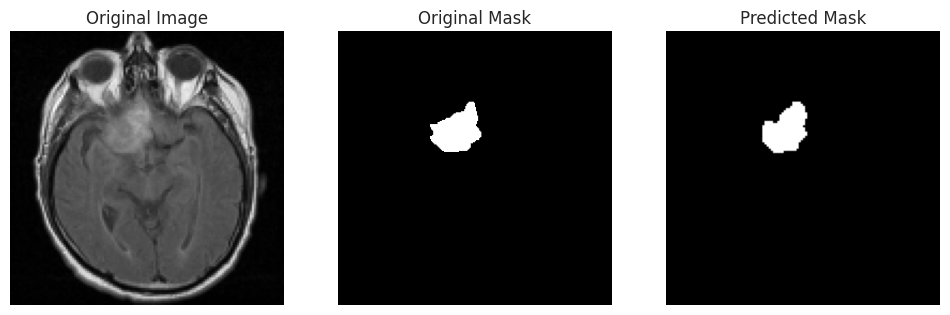

In [ ]:
for _ in range(20):
    index = npy.random.randint(1, len(test_df.index))

    # Load and preprocess the image
    img = opencv_img.imread(test_df['img_path'].iloc[index], 0)
    img = opencv_img.resize(img, (128, 128)) / 255.0
    img = img[npy.newaxis, :, :, npy.newaxis] # Changed np to npy

    # Predict the mask
    pred = unet_model.predict(img)

    # Plot the original image, original mask, and predicted mask
    pltx.figure(figsize=(12, 4))

    pltx.subplot(1, 3, 1)
    pltx.imshow(npy.squeeze(img), cmap='gray') # Changed np to npy
    pltx.title("Original Image")
    pltx.axis("off")

    pltx.subplot(1, 3, 2)
    mask = opencv_img.imread(test_df['mask_path'].iloc[index], 0)
    pltx.imshow(mask, cmap='gray')
    pltx.title("Original Mask")
    pltx.axis("off")

    pltx.subplot(1, 3, 3)
    pltx.imshow(npy.squeeze(pred) > 0.5, cmap='gray') # Changed np to npy
    pltx.title("Predicted Mask")
    pltx.axis("off")

    pltx.show()